# This practice will cover learning points in class2
### 1 - Fit MLR model in python with sklearn and statesmodel packages
### 2 - Model Selection
### 3 - Weighted regression
### 4 - Regularization, L1 and L2

Import required Python packages.

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

%matplotlib inline

no display found. Using non-interactive Agg backend


Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
DATA = Path('.').resolve().parents[1] / 'Practice\mlr'

HOUSE_CSV = DATA / 'house_sales.csv'

In [3]:
print(DATA)

print(HOUSE_CSV)

C:\Users\johnn\Desktop\github\DataScienceProgram\Class2\Practice\mlr
C:\Users\johnn\Desktop\github\DataScienceProgram\Class2\Practice\mlr\house_sales.csv


#### Data read and train-test split

In [4]:
houseall = pd.read_csv(HOUSE_CSV, sep='\t')

house, house_test = train_test_split(houseall, test_size=0.2)

print(house.head())
print(house.shape)

print(house_test.head())
print(house_test.shape)

      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
1034    2010-01-15     235000   390100060  Single Family  2010-01-01   350800   
3707    2007-03-05     265000  1330600020  Single Family  2007-03-01   429600   
25811   2008-05-20     692500  9402800016  Single Family  2008-05-01   407400   
1781    2008-01-07     525000   722079074  Single Family  2008-01-01   421900   
25059   2006-09-26     325000  9191201804  Single Family  2006-09-01   414800   

       zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  \
1034   0.806066      291539.0               1     7541  ...       1.00   
3707   0.987132      268454.0               1     7500  ...       1.00   
25811  0.936121      739755.0               1     3610  ...       1.75   
1781   0.969439      541550.0               1    60548  ...       2.00   
25059  0.953125      340984.0               1     3000  ...       1.00   

       Bedrooms  BldgGrade  YrBuilt  YrRenovated  TrafficNoise  Land

We can use the `LinearRegression` model from _scikit-learn_.

## 1 - Multiple Linear Regression (SKlearn)

In [5]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

print(house[subset].head())

       AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1034       291539.0           1040     7541       1.00         3          6
3707       268454.0           1200     7500       1.00         3          6
25811      739755.0           1280     3610       1.75         2          8
1781       541550.0           1800    60548       2.00         3          8
25059      340984.0            600     3000       1.00         2          6


In [6]:
print(house.head())
print(house.columns)

      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
1034    2010-01-15     235000   390100060  Single Family  2010-01-01   350800   
3707    2007-03-05     265000  1330600020  Single Family  2007-03-01   429600   
25811   2008-05-20     692500  9402800016  Single Family  2008-05-01   407400   
1781    2008-01-07     525000   722079074  Single Family  2008-01-01   421900   
25059   2006-09-26     325000  9191201804  Single Family  2006-09-01   414800   

       zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  \
1034   0.806066      291539.0               1     7541  ...       1.00   
3707   0.987132      268454.0               1     7500  ...       1.00   
25811  0.936121      739755.0               1     3610  ...       1.75   
1781   0.969439      541550.0               1    60548  ...       2.00   
25059  0.953125      340984.0               1     3000  ...       1.00   

       Bedrooms  BldgGrade  YrBuilt  YrRenovated  TrafficNoise  Land

In [7]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -515622.529
Coefficients:
 SqFtTotLiving: 233.98894170074954
 SqFtLot: -0.07934225840611603
 Bathrooms: -19710.315739508744
 Bedrooms: -48910.813239184536
 BldgGrade: 104511.73918684553


### Assessing the Model with performance KPIs
_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score` and `RMSE`.

In [9]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

fitted_test = house_lm.predict(house_test[predictors])
RMSE_test = np.sqrt(mean_squared_error(house_test[outcome], fitted_test))
r2_test = r2_score(house_test[outcome], fitted_test)
print(f'RMSE_test: {RMSE_test:.0f}')
print(f'r2_test: {r2_test:.4f}')

RMSE: 267160
r2: 0.5353
RMSE_test: 236057
r2_test: 0.5651


## 1 - Multiple Linear Regression (statsmodels)

While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [10]:
mlr_sm = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = mlr_sm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     4180.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:56:38   Log-Likelihood:            -2.5254e+05
No. Observations:               18149   AIC:                         5.051e+05
Df Residuals:                   18143   BIC:                         5.051e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   233.9889      4.455     52.528

### Correlations between predictors

Correlation Matrix 
                SqFtTotLiving   SqFtLot  Bathrooms  Bedrooms  BldgGrade
SqFtTotLiving       1.000000  0.200152   0.764335  0.597481   0.771353
SqFtLot             0.200152  1.000000   0.112071  0.069629   0.148971
Bathrooms           0.764335  0.112071   1.000000  0.532646   0.657224
Bedrooms            0.597481  0.069629   0.532646  1.000000   0.365227
BldgGrade           0.771353  0.148971   0.657224  0.365227   1.000000


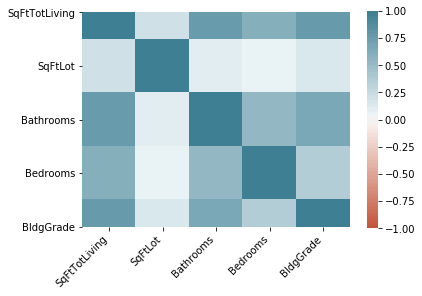

In [11]:
corr = house[predictors].corr()
print("Correlation Matrix \n {}".format(corr))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## 2 - Model Selection and Stepwise Regression

In [12]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

print("\nPredictors after nominal varibale(s) treatment: {} \n\n".format(X.shape))

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
1034            1040     7541       1.00         3          6  Single Family   
3707            1200     7500       1.00         3          6  Single Family   
25811           1280     3610       1.75         2          8  Single Family   
1781            1800    60548       2.00         3          8  Single Family   
25059            600     3000       1.00         2          6  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
1034                1                0     1951            0            False  
3707                1                0     1963            0            False  
25811               1                0     1926            0            False  
1781                1                0     1990            0            False  
25059               1                0     1951            0            False  

 PropertyType List 
Single Family    1

We can use the `stepwise_selection` method from the _dmba_ package.

In [ ]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

## 3 - Weighted regression
For the house data recent sale price is more relavent for future prediction, old sale data is less reliable, therefore, we like to emphasis the recent sale data by apply more weight. We will use year the house sale to 2005 as weight.

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [15]:
print("\nDocumentDate List \n{}".format(house['DocumentDate'].value_counts(dropna=False)))


DocumentDate List 
2006-06-28    48
2006-07-26    48
2006-05-30    45
2006-08-24    44
2006-06-01    44
              ..
2015-05-19     1
2011-12-07     1
2014-12-05     1
2012-02-16     1
2006-08-20     1
Name: DocumentDate, Length: 2461, dtype: int64


In [16]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]  #list comprehension
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))  # apply()
house['Weight'] = house.Year - 2005

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [17]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)

,predictor,house_lm,house_wt
0,SqFtTotLiving,233.988942,251.507898
1,SqFtLot,-0.079342,-0.320387
2,Bathrooms,-19710.315740,-27396.580318
3,Bedrooms,-48910.813239,-56081.766475
4,BldgGrade,104511.739187,112102.144966
5,intercept,-515622.529004,-562309.653883


       abs_residual_lm  abs_residual_wt  Year
1034     103783.669942    117725.486644  2010
3707      43257.186237     54386.087149  2007
25811    252378.874708    244581.529713  2008
1781       9144.393294      3234.484919  2008
25059    206912.697855    220297.318954  2006


Year   Abs_residual_lm    Abs_residual_wt
2006 140615.44627184205 146075.23269855397
2007 149644.77632330862 154564.0512862004
2008 144142.05445190886 148022.25129591255
2009 147838.35168361152 151530.1072899237
2010 165850.31372002384 168394.79604033942
2011 175127.67318058238 177277.46145572016
2012 166698.9682081134 168952.9549059125
2013 200126.84975968086 202463.684709197
2014 188033.3282023555 189693.43218758836
2015 185724.71915086126 183781.2482448893


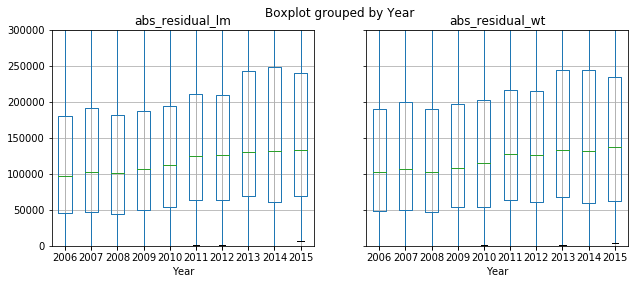

In [18]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)

print("\n\nYear   Abs_residual_lm    Abs_residual_wt")
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

Seems only help 2015 prediction reduce the residuale.If we have a recent holdout sample we can test the weight could help for furture prediction or not

# 4 - Regularization

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

outcome = 'AdjSalePrice'

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X_train = pd.get_dummies(house[predictors], drop_first=True)
X_train['NewConstruction'] = [1 if nc else 0 for nc in X_train['NewConstruction']]
y_train = house[outcome]

X_test = pd.get_dummies(house_test[predictors], drop_first=True)
X_test['NewConstruction'] = [1 if nc else 0 for nc in X_test['NewConstruction']]
y_test = house_test[outcome]

### Regular Multiple Regression

In [ ]:
house_lm = LinearRegression()
house_lm.fit(X_train, y_train)

mlr_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((house_lm.intercept_, house_lm.coef_), 
                                axis=None), 3))
)

mlr_coefs

In [ ]:
fitted_test = house_lm.predict(X_test)
MSE_test = np.sqrt(mean_squared_error(y_test, fitted_test))
r2 = r2_score(y_test, fitted_test)
print(f'regular mlr MSE: {MSE_test:.0f}')
print(f'r2_test: {r2:.4f}')

### L2 - Ridge regression (Parameter shrinkage)

In [ ]:
ridge_cv = RidgeCV(normalize=True, alphas=np.logspace(-10, 1, 400))
ridge_model = ridge_cv.fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_test)
ridge_mae = np.mean(np.abs(y_test - ridge_prediction))
ridge_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((ridge_model.intercept_, ridge_model.coef_), 
                                axis=None), 3))
)

print('Ridge Regression MAE: {}'.format(np.round(ridge_mae, 3)))
print('Ridge Regression coefficients:')
ridge_coefs

### L1 - Lasso regression (Parameter sparsity)

In [ ]:
lasso_cv = LassoCV(normalize=True, alphas=np.logspace(-10, 1, 400))
lasso_model = lasso_cv.fit(X_train, y_train)
lasso_prediction = lasso_model.predict(X_test)
lasso_mae = np.mean(np.abs(y_test - lasso_prediction))
lasso_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((lasso_model.intercept_, lasso_model.coef_), axis=None), 3))
)

print('LASSO MAE: {}'.format(np.round(lasso_mae, 3)))
print('LASSO coefficients:')
lasso_coefs

# Home Work

1. Compare the three model fits and draw conclusion 
from the comparision of the three model firt regarding there coefficent difference

2. Show the three model performance on both tran and test